In [33]:
from thredds_crawler.crawl import Crawl
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import pickle as pk
import subprocess
import os
import gc

In this example we will explore data from a Bottom Pressure and Tilt (BOTPT) sensor in the Central Caldera location of Axial Seamount.  It is one of 4 BOTPT sensors in the OOI Cabled Array System. http://ooi.visualocean.net/instruments/all#search=botpt

Each instrument is sampling bottom pressure and tilt at 20 Hz. Thus, 3 years of data from the instrument is a sizeable amount and poses some difficulty during processing and analysis.

Because of the size in data and the fact that OOI data is processed on demand, we have staged a pre-processed dataset on the thredds server for immidiate access. This dataset was requested using the steps outlined in 00_botpt_data_request.ipynb.

In [29]:
url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/friedrich.knuth@rutgers.edu/20171207T161702-RS03CCAL-MJ03F-05-BOTPTA301-streamed-botpt_nano_sample/catalog.html'

Now let's use the thredds crawler to gather the dataset urls off the thredds server.

In [ ]:
url = url.replace('.html', '.xml')
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
c = Crawl(url, select=[".*\.nc$"], debug=False)
datasets = [os.path.join(tds_url, x.id) for x in c.datasets]

## Data Wrangling Option 1
Instead of downloading a local copy of the data, we can read each thredds data url directly into xarray, then use pandas to resample the 20 Hz data to the mean value per minute and finally write out the resamples pandas dataframe as a pickle file.  

In [50]:
# make the output directory
new_dir = 'data/min_data/'
if not os.path.isdir(new_dir):
    try:
        os.mkdirs(new_dir)
    except OSError:
        if os.path.exists(new_dir):
            pass
        else:
            raise

AttributeError: 'module' object has no attribute 'mkdirs'

In [30]:
# read in the data directly off THREDDS and write out as subsampled pickled pandas dataframe
num = 0
for i in datasets:
    ds = xr.open_dataset(i)
    ds = ds.swap_dims({'obs': 'time'})

    pressure_min = pd.DataFrame()
    pressure_min['bottom_pressure'] = ds['bottom_pressure'].to_pandas().resample('T').mean()
    del pressure_min.index.name

    pressure_min = pressure_min.dropna()

    out = 'data/min_data/' + i.split('/')[-1][:-3] + '_resampled' + '.pd'
    num = num +1

    with open(out, 'wb') as fh:
        pk.dump(pressure_min,fh)

    gc.collect()

Next we will load in the individual pickle files and create a single concatenated dataset at 1 sample per minute.

In [37]:
pressure_min = pd.DataFrame()
for path, subdirs, files in os.walk('data/min_data/'):
    for name in files:
        file_name = os.path.join(path, name) 
        with open(file_name, 'rb') as f:
            pd_df = pk.load(f)
            pressure_min = pressure_min.append(pd_df)

with open('data/pressure_min.pd', 'wb') as f:
    pk.dump(pressure_min,f)

<function matplotlib.pyplot.show>

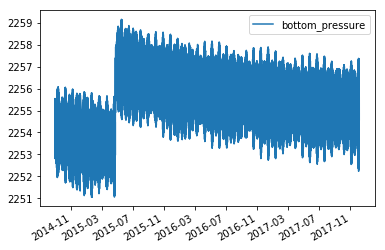

In [38]:
pressure_min.plot()
plt.show

## Data Wrangling Option 2
It should be possible to use xr.open_mfdataset() and dask to load all the data in at once, prior to subsampling by the mean value of every minute, however, I have not been able to get this to work in a timely manner. I does work on datasets that are only a few GB, but this dataset is ~ 60 GB of data, which makes it difficult to load, unless there are ways to optimize the use of Dask.

In [ ]:
ds = xr.open_mfdataset(datasets)

## Dowloading the data to your local machine before processing
As an alternative to reading the data directly off thredds you can use wget to download the data locally. Note that the dataset url points to an Apache file server instance, instead of the THREDDS instance of the data. Both urls are provided when initiatially requesting the data in botpt_data_request.ipynb.

In [ ]:
download_data = 'wget -r -l1 -nd -nc -np -e robots=off -A.nc --no-check-certificate https://opendap.oceanobservatories.org/async_results/friedrich.knuth@rutgers.edu/20180116T155221-RS03ASHS-MJ03B-09-BOTPTA304-streamed-botpt_nano_sample/'
subprocess.call(download_data, shell=True) 